In [1]:
# !pip install gymnasium
# !pip install matplotlib
# !pip install torch
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

Let's determing following blocks:

- Hyperparameters
- Environment
- Policy

In [8]:
# --- Hyperparameters ---
class cfg:
    env_name = "CartPole-v1"
    learning_rate = 1e-2
    gamma = 0.99
    hid_dim = 128
    episodes = 700
    num_envs = 20


# --- Create environment ---
# env = gym.make('CartPole-v1',render_mode="human")
env = gym.make(cfg.env_name)


# --- Policy network ---
class PolicyNet(nn.Module):
    def __init__(self, obs_dim, n_actions, hid_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, n_actions),
            nn.Softmax(dim=-1),
        )

    def forward(self, x):
        probs = self.net(x)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        return action, log_prob

    def act(self, x):
        probs = self.net(x)
        return torch.argmax(probs)


policy = PolicyNet(env.observation_space.shape[0], env.action_space.n, cfg.hid_dim)
optimizer = optim.Adam(policy.parameters(), lr=cfg.learning_rate)

In [9]:
# --- Function to compute reward-to-go ---
def compute_reward_to_go(rewards, gamma):
    rtg = np.zeros_like(rewards, dtype=np.float32)
    running_add = 0
    for t in reversed(range(len(rewards))):
        running_add = rewards[t] + gamma * running_add
        rtg[t] = running_add
    return rtg


# --- Training loop ---
reward_hist = []
for episode in range(cfg.episodes):
    state, _ = env.reset()
    log_probs = []
    rewards = []

    while True:
        state_tensor = torch.from_numpy(state).float()
        action, log_prob = policy(state_tensor)
        state, reward, done, truncated, _ = env.step(action.item())

        log_probs.append(log_prob)
        rewards.append(reward)
        if done or truncated:
            break

    # Compute reward-to-go and normalize
    rtg = compute_reward_to_go(rewards, cfg.gamma)
    rtg = torch.tensor(rtg)
    rtg = (rtg - rtg.mean()) / (rtg.std() + 1e-9)

    # Compute loss and update policy
    loss = 0
    for log_prob, Gt in zip(log_probs, rtg):
        loss -= log_prob * Gt

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Logging
    total_reward = sum(rewards)
    reward_hist.append(total_reward)
    if episode % 10 == 0:
        print(f"Episode {episode}, total reward: {total_reward}")

env.close()

Episode 0, total reward: 18.0
Episode 10, total reward: 43.0
Episode 20, total reward: 50.0
Episode 30, total reward: 42.0
Episode 40, total reward: 121.0
Episode 50, total reward: 171.0
Episode 60, total reward: 33.0
Episode 70, total reward: 52.0
Episode 80, total reward: 119.0
Episode 90, total reward: 170.0
Episode 100, total reward: 157.0
Episode 110, total reward: 239.0
Episode 120, total reward: 279.0
Episode 130, total reward: 277.0
Episode 140, total reward: 269.0
Episode 150, total reward: 302.0
Episode 160, total reward: 500.0
Episode 170, total reward: 500.0
Episode 180, total reward: 349.0
Episode 190, total reward: 500.0
Episode 200, total reward: 500.0
Episode 210, total reward: 401.0
Episode 220, total reward: 500.0
Episode 230, total reward: 198.0
Episode 240, total reward: 500.0
Episode 250, total reward: 500.0
Episode 260, total reward: 500.0
Episode 270, total reward: 500.0
Episode 280, total reward: 500.0
Episode 290, total reward: 500.0
Episode 300, total reward: 

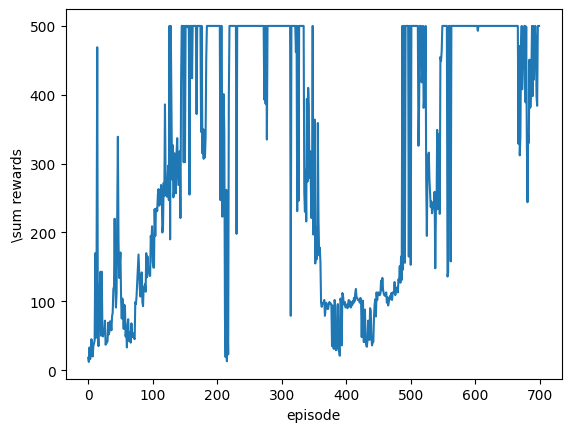

In [10]:
plt.plot(reward_hist)
plt.ylabel("\sum rewards")
plt.xlabel("episode")
plt.show()

In [5]:
# --- Hyperparameters ---
class cfg:
    env_name = "CartPole-v1"
    learning_rate = 1e-2
    gamma = 0.99
    hid_dim = 8
    episodes = 400
    num_envs = 15


policy = PolicyNet(env.observation_space.shape[0], env.action_space.n, cfg.hid_dim)
optimizer = optim.Adam(policy.parameters(), lr=cfg.learning_rate)

# --- Training loop ---
reward_hist = []
for episode in range(cfg.episodes):
    episode_rewards = []
    for env_id in range(cfg.num_envs):
        state, _ = env.reset()
        log_probs = []
        rewards = []
        loss_terms = []
        while True:
            state_tensor = torch.from_numpy(state).float()
            action, log_prob = policy(state_tensor)
            state, reward, done, truncated, _ = env.step(action.item())

            log_probs.append(log_prob)
            rewards.append(reward)
            if done or truncated:
                break
        episode_rewards.append(sum(rewards))
        # Compute reward-to-go and normalize
        rtg = compute_reward_to_go(rewards, cfg.gamma)
        rtg = torch.tensor(rtg)
        rtg = (rtg - rtg.mean()) / (rtg.std() + 1e-9)

        # Compute loss and update policy
        for log_prob, Gt in zip(log_probs, rtg):
            loss_terms.append(-log_prob * Gt)

    loss = torch.stack(loss_terms).sum()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Logging
    total_reward = np.mean(episode_rewards)
    reward_hist.append(total_reward)
    if episode % 10 == 0:
        print(f"Episode {episode}, mean reward: {total_reward}")

env.close()

Episode 0, mean reward: 20.066666666666666
Episode 10, mean reward: 19.066666666666666
Episode 20, mean reward: 17.0
Episode 30, mean reward: 23.8
Episode 40, mean reward: 16.6
Episode 50, mean reward: 21.266666666666666
Episode 60, mean reward: 29.8
Episode 70, mean reward: 29.0
Episode 80, mean reward: 35.733333333333334
Episode 90, mean reward: 18.066666666666666
Episode 100, mean reward: 28.6
Episode 110, mean reward: 32.333333333333336
Episode 120, mean reward: 33.13333333333333
Episode 130, mean reward: 50.86666666666667
Episode 140, mean reward: 75.93333333333334
Episode 150, mean reward: 91.33333333333333
Episode 160, mean reward: 73.73333333333333
Episode 170, mean reward: 88.6
Episode 180, mean reward: 169.33333333333334
Episode 190, mean reward: 128.6
Episode 200, mean reward: 117.86666666666666
Episode 210, mean reward: 188.0
Episode 220, mean reward: 151.4
Episode 230, mean reward: 144.93333333333334
Episode 240, mean reward: 151.06666666666666
Episode 250, mean reward: 14

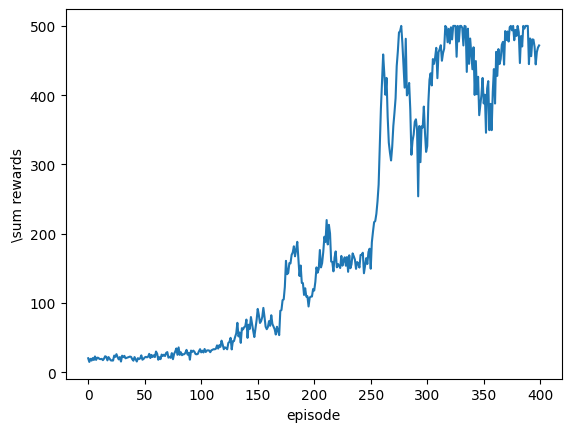

In [6]:
plt.plot(reward_hist)
plt.ylabel("\sum rewards")
plt.xlabel("episode")
plt.show()

In [11]:
import time

policy.eval()
env = gym.make("CartPole-v1", render_mode="human")
state, _ = env.reset()
total_reward = 0

while True:
    env.render()  # open a render window
    time.sleep(0.02)  # slow it down a bit (optional)

    state_tensor = torch.from_numpy(state).float()
    with torch.no_grad():
        action = policy.act(state_tensor).item()

    state, reward, done, truncated, _ = env.step(action)
    total_reward += reward
    if done or truncated:
        break

env.close()
print(f"Total reward in evaluation: {total_reward}")

Total reward in evaluation: 500.0
